# Model Comparison: KNN Regression and OLS Regression

Comparing models is something data scientists do all the time. There's very rarely just one model that would be possible to run for a given situation, so learning to choose the best one is very important.

This dataset, entitled [FIFA 19 Complete Player Dataset]('https://www.kaggle.com/karangadiya/fifa19'), was taken from Kaggle. In this model comparison, we will use a number of features to create two different models - KNN Regression and OLS Regression - that predict a player's wage. Once these models have been created, we will compare their similarities and differences.

In [1]:
import pandas as pd
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
full_df = pd.read_csv('fifa19.csv')
df = full_df.drop(['Unnamed: 0','Photo','Flag','Club Logo','Real Face'],axis=1)
df.head()

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,€77M,€405K,2228,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,193080,De Gea,27,Spain,91,93,Manchester United,€72M,€260K,1471,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,€102M,€355K,2281,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [3]:
df.shape

(18207, 84)

In [4]:
df.dtypes
df.dtypes[df.dtypes != 'int64'][df.dtypes != 'float64']

Name                    object
Nationality             object
Club                    object
Value                   object
Wage                    object
Preferred Foot          object
Work Rate               object
Body Type               object
Position                object
Joined                  object
Loaned From             object
Contract Valid Until    object
Height                  object
Weight                  object
LS                      object
ST                      object
RS                      object
LW                      object
LF                      object
CF                      object
RF                      object
RW                      object
LAM                     object
CAM                     object
RAM                     object
LM                      object
LCM                     object
CM                      object
RCM                     object
RM                      object
LWB                     object
LDM                     object
CDM     

In [5]:
df.Value = df.Value.apply(lambda x: x.strip('€'))
df.Value = df.Value.replace(r'[KM]+$', '', regex=True).astype(float) * \
            df.Value.str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int)

df.Wage = df.Wage.apply(lambda x: x.strip('€'))
df.Wage = df.Wage.replace(r'[KM]+$', '', regex=True).astype(float) * \
            df.Wage.str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int)

df.head()

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,110500000.0,565000.0,2202,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77000000.0,405000.0,2228,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,2143,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,193080,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,1471,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000.0,355000.0,2281,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


### Selecting Features

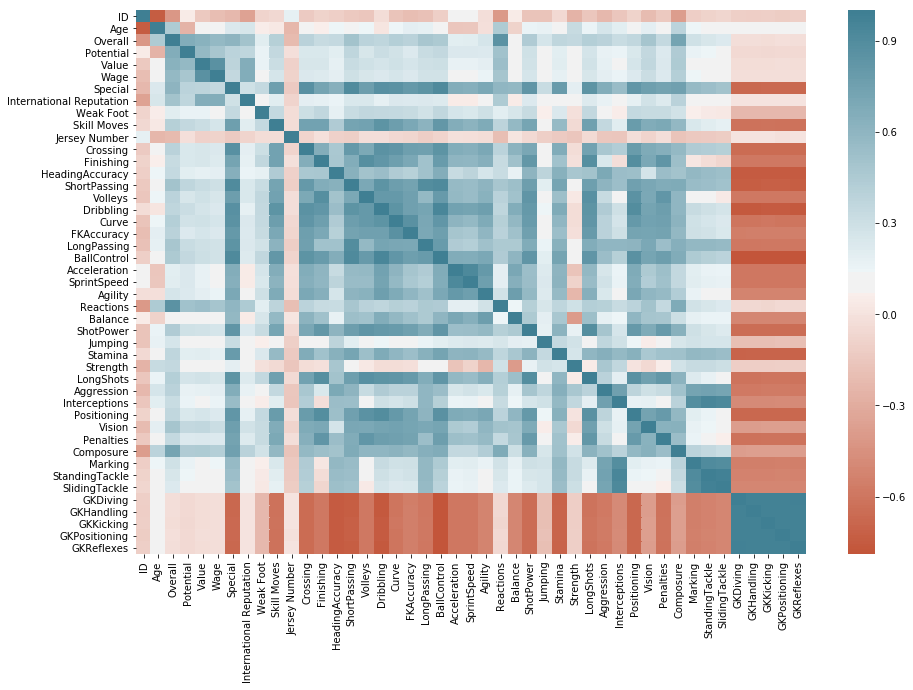

In [6]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), cmap=sns.diverging_palette(20, 220, n=200))

For wage, there are higher correlations with Overall, International Reputation, Reactions, and Composure. For the purposes of this assignment, these will be the independent variables used to predict the dependent variable of Wage.

In [7]:
features_complete = df[['Overall','International Reputation','Reactions','Composure']]

# Dropping the 48 rows of 18207 total that do not contain feature information
features = features_complete.drop(features_complete[features_complete.isnull().any(axis=1)].index)
features.isnull().sum()

Overall                     0
International Reputation    0
Reactions                   0
Composure                   0
dtype: int64

### Creating the KNN Regression Model

After running a *for loop* with neighbor numbers ranging from 1 through 100 to find the most accurate model, k=39 was the most accurate KNN Regression Model according to the specifications listed in the cell below. However, it was not very accurate.

In [8]:
knn = neighbors.KNeighborsRegressor(n_neighbors=39, weights='distance')
X = features
Y = df.Wage.drop(list(features_complete[features_complete.isnull().any(axis=1)].index))
knn.fit(X, Y)

Y_=knn.predict(X)

score = cross_val_score(knn, X, Y, cv=10)
print("Weighted Accuracy in Cross-Validation: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
print('\nR-squared: ' + str(knn.score(X, Y)))

Weighted Accuracy in Cross-Validation: -0.19 (+/- 0.17)

R-squared: 0.9522326927479647


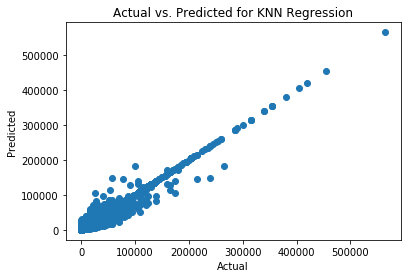

In [9]:
plt.scatter(Y,Y_)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted for KNN Regression')
plt.show()

### Creating the OLS Regression Model

In [10]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
X = features
Y = df.Wage.drop(list(features_complete[features_complete.isnull().any(axis=1)].index))
regr.fit(X, Y)

Y_=regr.predict(X)


# Inspect the results.
score = cross_val_score(regr, X, Y, cv=10)
print("Accuracy in Cross-Validation: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
print('\nR-squared: ' + str(regr.score(X, Y)))

Accuracy in Cross-Validation: -44.01 (+/- 250.72)

R-squared: 0.5226605310489705


In [11]:
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 1.05980116e+03  2.85802130e+04  4.08454119e+00 -4.71812720e+01]

Intercept: 
 -89760.7489712273

R-squared:
0.5226605310489705


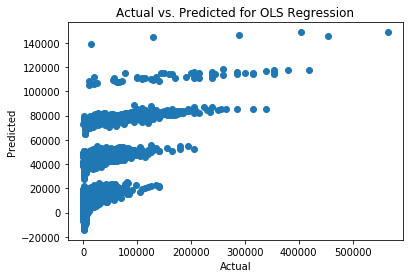

In [12]:
plt.scatter(Y,Y_)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted for OLS Regression')
plt.show()

#### Reviewing the Models
For this dataset and the features chosen, it is evident that the KNN Regression Classifier outperforms the Multivariable Linear Regression. The r-squared values between the two models vary by over 40% percent in favor of KNN, and the scatter plots of Actual vs Predicted clearly show KNN as the stronger model in identifying the regression pattern between the features and continuous target variable of player's wage.

That being said, a noticeable weakness in the KNN Regression Model can be found in the lower-left quadrant for the less desireable players. However, even in this area, KNN still beats OLS.

#### Why Is This the Case?
The OLS Regression attempts to minimize error between predicted and actual target variables by assigning features weighted coefficients. The downside of this method is that when there is considerable variance within a feature (such as the feature "International Reputation" with an OLS coefficient of 28580.2) the model will not have the versatility to account for high variance within that feature since every datapoint of that feature is treated with the exact same coefficient.

On the other hand, the KNN Regression has the versatility to not only weight the features as a whole but also the variance within the features. For this reason, the KNN Regression model significantly outperforms the OLS Regression model.